# DiD Role of Autocorrelation and Trend Size
Julian Hsu
31 january 2023

While panel methods, specifically DiD, are highly sought after causal tools because their validity can be tested, one drawback is that they can require a lot of data. They require a panel dataset where units are observed over time. This can place a large burden on data anlyses and potential turnoff their use.

This script's objective is to show how a relatively small panel can provide estimates using DiD, and examples under which that estimate is biased. We focus on how correlated the outcomes are over-time.


**18mar2023 update** let's just look at the relationship between bias and AR. Increasing the trend size is complicated by how many periods we have to start out with, and the effect size is also complicated with AR.

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm



In [123]:
'''

Generate a dataset where the series of outcomes are correlated over time.
We all at least one pre-treatment period, and only one post-treatment period.
We also only treat one unit.

'''

def data_with_ar(ar=0, preT=20, atet=0, N=5):
    initial_x = np.random.normal(0,1,N) 
    x_old = np.random.normal(0,1,N)
    output_df = pd.DataFrame(data={'y':x_old+initial_x, 'unit': np.arange(N), 'time':np.zeros(N)})
    
    assert (preT > 7),'Need at least two pre-treatment periods'
    
    ## Create an series of outcomes that are correlated over time.
    for t in range(preT):
        if t==0:
            pass
        else:
            x_new = initial_x+x_old*(ar) + np.random.normal(0,1,N)*(1-ar)
            output_df = pd.concat([output_df,
                pd.DataFrame(data={'y':x_new, 'unit': np.arange(N), 'time':np.ones(N)*t})])
            x_old = x_new[:]
    ## Only allow one unit to be treated    
    ## Do the last five units are the post period
    x_new = x_old*(ar) + np.random.normal(0,1,N)*(1-ar) + np.random.normal(0,1,N)
    output_df = pd.concat([output_df,
        pd.DataFrame(data={'y':x_new, 'unit': np.arange(N), 'time':np.ones(N)*t+1})])
    output_df['treated'] = 0
    output_df['post'] = 0
    output_df.loc[ (output_df['unit']==0) & (output_df['time']>=preT-5) , 'y'] += atet
    output_df.loc[ (output_df['unit']==0) , 'treated'] =1
    
    output_df.loc[ (output_df['time'] >= preT-5) , 'post'] =1
    
    return output_df

    

In [124]:
'''
Simple DiD, putting inference aside.
'''
def did_simp(data=None):
    ## Pre-treatment, control
    pre_c = data.loc[(data['treated']==0) & (data['post']==0)]['y'].mean()
    ## Pre-treatment, treat
    pre_t = data.loc[(data['treated']==1) & (data['post']==0)]['y'].mean()
    
    ## Post-treatment, control
    pst_c = data.loc[(data['treated']==0) & (data['post']==1)]['y'].mean()
    ## Post-treatment, treat
    pst_t = data.loc[(data['treated']==1) & (data['post']==1)]['y'].mean()
    
    ## simple atet estimate
    atet_est = (pst_t - pst_c) - (pre_t - pre_c)
    return atet_est
    

In [141]:
N = 50
preT = 10
atet=10
ar = 0.8

df = data_with_ar(ar=ar, preT=10, atet=atet, N=N)


In [142]:
def ar_lazy(data=None):
    ## Calculcate auto-correlations without using time format variables
    time_list = data['time'].unique().tolist()
    time_list.sort()
    corr = []
    for i in range(len(time_list)-1):
        pre,post = time_list[i], time_list[i+1]
        a = data.loc[data['time']==pre][['unit','y']].merge(
            data.loc[data['time']==post][['unit','y']], how='inner',on='unit')
        corr.append( a[['y_x','y_y']].corr().iloc[0,1] )
    return corr

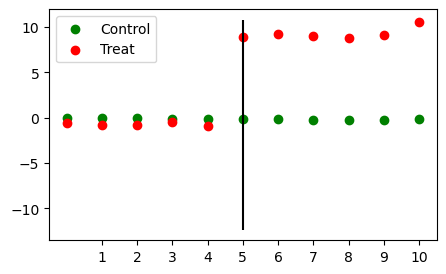

In [143]:
plot_control = df.loc[df['treated']==0].groupby('time')['y'].mean()
plot_treat = df.loc[df['treated']==1].groupby('time')['y'].mean()

fig,ax = plt.subplots(ncols=1,nrows=1, figsize=(5,3))

ax.scatter(x = plot_control.index, y=plot_control, color='green', label='Control')
ax.scatter(x = plot_treat.index, y=plot_treat, color='red', label='Treat')
ax.vlines(x = preT-5, ymax=df['y'].max(), ymin=df['y'].min() , color='black')
ax.legend()
ax.set_xticks(np.arange(1,preT+1))
ax.set_xticklabels(np.arange(1,preT+1))
plt.show()


For different auto-correlation values, calculate the atet and bias.
Also run a few bootstraps to rule out simulation noise.
In order to fully deep dive the simulations, record the individual result from each simulation.

In [132]:
atet_list = []
ar_list = [0.10,0.30,0.50,0.75,0.90]
pret_list = [2,5,10]
## Ground truth is in terms of standard deviations of the initial period
true_gt = [0.05,1,5]

sim_number = 100
t = 15

sim_results = pd.DataFrame()
for gt in true_gt:
    for a in ar_list:
        atet_sim = []
        est_ar_list = []
        for s in range(sim_number):
            df = data_with_ar(ar=a, preT=t, atet=gt, N=500)
            atet_est = did_simp(data=df)
            sim_results = pd.concat([sim_results, 
                                            pd.DataFrame(index=[s],data={'ar':a,
                                                                         'pret':t, 
                                                                         'gt':gt,
                                                                         'atet':atet_est, 'bias': np.abs(atet_est- gt),
                                                                        'mape': np.abs(atet_est - gt)/gt})])



In [133]:
display( sim_results.groupby(['gt','ar'])[['atet','bias']].describe().T )

gt                0.05                                                  \
ar                0.10        0.30        0.50        0.75        0.90   
atet count  100.000000  100.000000  100.000000  100.000000  100.000000   
     mean    -0.003009    0.134199    0.045990    0.047529    0.808466   
     std      0.549674    0.490457    0.528558    1.330072    3.577483   
     min     -1.411165   -1.027642   -1.338442   -4.419802   -7.900433   
     25%     -0.412720   -0.243238   -0.321174   -0.822076   -1.560646   
     50%      0.052946    0.198721   -0.053442    0.006635    0.629582   
     75%      0.319104    0.429616    0.360029    0.988336    3.222332   
     max      1.338879    1.221610    1.350225    3.306662    9.299078   
bias count  100.000000  100.000000  100.000000  100.000000  100.000000   
     mean     0.431057    0.409210    0.420434    1.013504    2.916484   
     std      0.342480    0.280294    0.317552    0.855297    2.188074   
     min      0.003569    0.007237    0.001341    0.010174    0.044035   
     25%      0.162855    0.189866    0.183110    0.324017    1.055960   
     50%      0.337629    0.320080    0.356513    0.931875    2.529684   
     75%      0.593488    0.623351    0.570605    1.513091    4.148266   
     max      1.461165    1.171610    1.388442    4.469802    9.249078   

gt                1.00                                                  \
ar                0.10        0.30        0.50        0.75        0.90   
atet count  100.000000  100.000000  100.000000  100.000000  100.000000   
     mean     0.993425    1.054264    0.994204    0.989814    1.451931   
     std      0.525268    0.549607    0.484592    1.173042    3.542863   
     min     -0.142780   -0.242928   -0.274388   -1.633702   -9.860790   
     25%      0.613170    0.615302    0.715108    0.376255   -0.810062   
     50%      0.980740    1.044823    1.087193    0.968263    1.541623   
     75%      1.351123    1.478291    1.339863    1.726154    3.542050   
     max      2.499147    2.872774    2.174967    4.060747   11.164178   
bias count  100.000000  100.000000  100.000000  100.000000  100.000000   
     mean     0.415800    0.441986    0.397288    0.911467    2.740475   
     std      0.318298    0.328202    0.274647    0.732782    2.274230   
     min      0.001346    0.017509    0.001239    0.008238    0.205700   
     25%      0.161210    0.178892    0.206152    0.329390    1.155695   
     50%      0.375570    0.397297    0.316458    0.690151    2.192019   
     75%      0.526791    0.638138    0.567089    1.388218    3.567087   
     max      1.499147    1.872774    1.274388    3.060747   10.860790   

gt                5.00                                                  
ar                0.10        0.30        0.50        0.75        0.90  
atet count  100.000000  100.000000  100.000000  100.000000  100.000000  
     mean     5.012105    5.042207    5.022448    4.923101    4.784652  
     std      0.590885    0.539228    0.502552    1.201371    3.353520  
     min      2.995797    3.441085    3.697925    2.309520   -2.424974  
     25%      4.740566    4.745864    4.717013    4.189372    2.076427  
     50%      5.018655    5.082858    4.999088    4.934568    5.005339  
     75%      5.359157    5.403706    5.337556    5.703680    7.075818  
     max      6.928530    6.196984    6.449733    8.025170   12.614118  
bias count  100.000000  100.000000  100.000000  100.000000  100.000000  
     mean     0.422326    0.431226    0.385016    0.961704    2.738203  
     std      0.411257    0.323622    0.321455    0.717670    1.928588  
     min      0.000733    0.001950    0.004776    0.020452    0.018334  
     25%      0.115806    0.186476    0.112900    0.405950    1.293359  
     50%      0.332499    0.354757    0.322347    0.806325    2.327024  
     75%      0.638225    0.628854    0.543979    1.352913    3.913175  
     max      2.004203    1.558915    1.449733    3.025170    7.614118

In [134]:
# plt.scatter(x=sim_results['ar'], y=sim_results['est_ar'])
# plt.xlabel('AR')
# plt.ylabel('Estimated AR')
# sim_results['est_ar_rnd'] = np.round(sim_results['est_ar'],1)

In [135]:
display(sim_results.describe())

,ar,pret,gt,atet,bias,mape
count,1500.000000,1500.0,1500.000000,1500.000000,1500.000000,1500.000000
mean,0.510000,15.0,2.016667,2.086755,1.002412,7.313899
std,0.290614,0.0,2.145606,2.680537,1.392102,19.226673
min,0.100000,15.0,0.050000,-9.860790,0.000733,0.000147
25%,0.300000,15.0,0.050000,0.222533,0.227211,0.136468
50%,0.500000,15.0,1.000000,1.247110,0.519626,0.579710
75%,0.750000,15.0,5.000000,4.629250,1.107487,5.098133
max,0.900000,15.0,5.000000,12.614118,10.860790,184.981559


<BarContainer object of 5 artists>

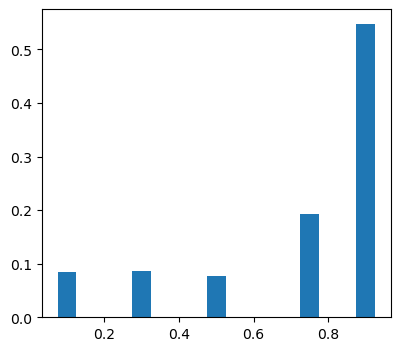

In [145]:
fig, ax = plt.subplots(ncols=1,nrows=1, figsize=(4.5*1, 4))         # Sample figsize in inches
disp_data=sim_results.groupby(['gt','ar'])[['atet','bias','mape']].mean().reset_index() 
ax.bar(x=disp_data.loc[disp_data['gt']==5]['ar'],
         height=disp_data.loc[disp_data['gt']==5]['mape'],
      width=0.05)

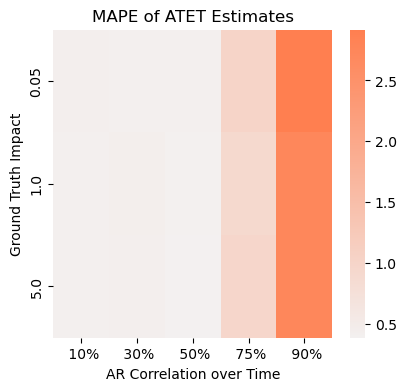

<Figure size 640x480 with 0 Axes>

In [137]:
'''
Look at how bias varies over these different dimensions with heatmaps.
'''
fig, ax = plt.subplots(ncols=1,nrows=1, figsize=(4.5*1, 4))         # Sample figsize in inches

sim_results['mape_disp'] = sim_results['mape']*100


import seaborn as sns
mape_heatmap = pd.pivot_table(data=sim_results, columns='ar',index='gt', aggfunc='mean', values=['bias'])

sns.heatmap(mape_heatmap,
#             xticklabels = [ np.round(e,2) for e in ar_list],
           xticklabels=['{0:3.0f}%'.format(x*100) for x in ar_list],
            cmap=sns.light_palette("coral", as_cmap=True) )
ax.set_xlabel('AR Correlation over Time')
ax.set_ylabel('Ground Truth Impact')
ax.set_title('MAPE of ATET Estimates')

plt.show()
plt.tight_layout()

In [ ]:
# '''
# Look at how bias varies over these different dimensions with heatmaps.
# '''
# fig, ax = plt.subplots(ncols=2,nrows=1, figsize=(4*2,4))         # Sample figsize in inches

# sim_results['mape_disp'] = sim_results['mape']*100


# import seaborn as sns
# mape_heatmap = pd.pivot_table(data=sim_results, columns='ar',index='pret', values=['mape_disp'])

# sns.heatmap(mape_heatmap,
# #             xticklabels = [ np.round(e,2) for e in ar_list],
#            xticklabels=['{0:3.0f}%'.format(x*100) for x in ar_list],
#             cmap=sns.light_palette("seagreen", as_cmap=True) ,
#            ax=ax[0])
# ax[0].set_xlabel('AR Correlation over Time')
# ax[0].set_ylabel('Number of Pre-Treatment Periods')
# ax[0].set_title('MAPE of DiD Estimate Bias')

# # Manually specify colorbar labelling after it's been generated
# tick_range = np.arange( mape_heatmap.min().min(),
#                       mape_heatmap.max().max(),
#                       0.10)
# colorbar = ax[0].collections[0].colorbar
# colorbar.set_ticks(tick_range)
# colorbar.set_ticklabels(['{0:2.0f}%'.format(x*100) for x in tick_range] )


# mape_heatmap = pd.pivot_table(data=sim_results, columns='ar',index='gt', values=['mape_disp'])

# sns.heatmap(mape_heatmap,
# #             xticklabels = [ np.round(e,2) for e in ar_list],
#            xticklabels=['{0:3.0f}%'.format(x*100) for x in ar_list],
#             cmap=sns.light_palette("coral", as_cmap=True) ,
#            ax=ax[1])
# ax[1].set_xlabel('AR Correlation over Time')
# ax[1].set_ylabel('Ground Truth Impact')
# ax[1].set_title('MAPE of DiD Estimate Bias')
# tick_range = np.arange( mape_heatmap.min().min(),
#                       mape_heatmap.max().max(),
#                       0.10)
# colorbar = ax[1].collections[0].colorbar
# colorbar.set_ticks(tick_range)
# colorbar.set_ticklabels(['{0:2.0f}%'.format(x*100) for x in tick_range] )

# plt.tight_layout()
# plt.show()
